In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import numpy as np

# Set plot style
sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('clean_history_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         9 non-null      int64  
 1   quiz_id                    9 non-null      int64  
 2   user_id                    9 non-null      object 
 3   submitted_at               9 non-null      object 
 4   created_at                 9 non-null      object 
 5   updated_at                 9 non-null      object 
 6   score                      9 non-null      int64  
 7   trophy_level               9 non-null      int64  
 8   accuracy                   9 non-null      float64
 9   speed                      9 non-null      float64
 10  final_score                9 non-null      float64
 11  negative_score             9 non-null      float64
 12  correct_answers            9 non-null      int64  
 13  incorrect_answers          9 non-null      int64  
 14

In [65]:
# ------------------------- 1. Prepare Training dataset -------------------------

# Selecting relevant features
features = ["accuracy", "time_per_correct", "time_per_incorrect", "success_rate",
    "difficulty", "effective_accuracy", "quiz_total", "questions_attempted",
    "total_time_taken", "avg_response_time", "completion_rate", "quiz_time_pressure"
]

# Define target variable (Categorizing performance into 3 classes based on rank)
def categorize_performance(rank):
    if rank < 500:
        return "Excellent"
    elif rank > 500 and rank<5000:
        return "Good"
    else:
        return "Needs Improvement"

# Apply target variable categorization
df["performance_category"] = df["rank"].apply(categorize_performance)

# Encoding categorical features
label_encoder = LabelEncoder()
df["performance_category"] = label_encoder.fit_transform(df["performance_category"])  # Convert labels to numbers

# Split data into features (X) and target (y)
X = df[features].copy()
y = df["performance_category"]

# Train-test split (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [68]:
# ------------------------- 2. Train Machine Learning Model -------------------------

# Initialize and train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight="balanced")
model.fit(X_train, y_train)

joblib.dump(model, "model.pkl")

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_, labels=[0, 1, 2], zero_division=0))

Model Accuracy: 0.6666666666666666

Classification Report:
                    precision    recall  f1-score   support

        Excellent       0.00      0.00      0.00         1
             Good       0.50      1.00      0.67         1
Needs Improvement       1.00      1.00      1.00         1

         accuracy                           0.67         3
        macro avg       0.50      0.67      0.56         3
     weighted avg       0.50      0.67      0.56         3



Accuracy can be greatly improved with more training data

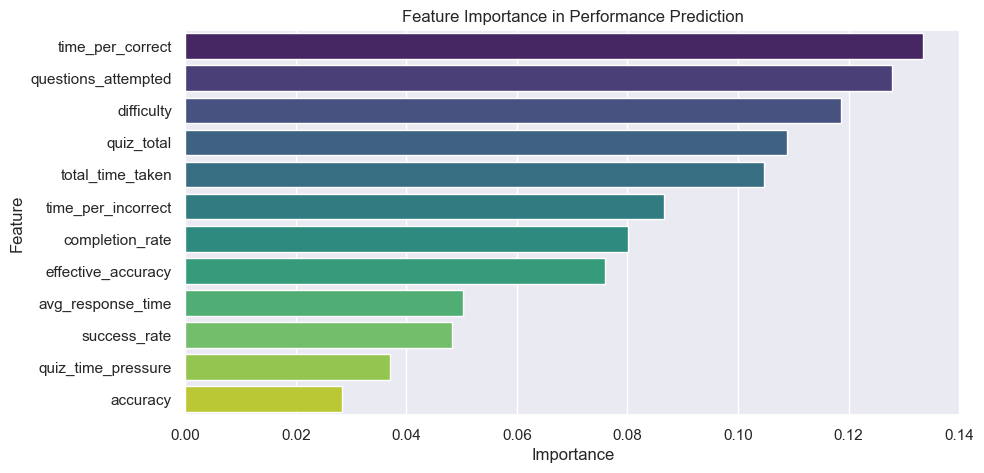

In [38]:
# ------------------------- 3. Feature Importance Analysis -------------------------

# Get feature importance scores
feature_importance = pd.DataFrame({"Feature": list(X.columns), "Importance": model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature",hue="Feature", data=feature_importance, palette="viridis")
plt.title("Feature Importance in Performance Prediction")
plt.show()

In [53]:
# ------------------------- 4. Generate Insights -------------------------

def generate_insights(user_data, label_encoder, scaler, model):
    """Generate performance insights based on model predictions, feature importance, and outlier detection."""
    features = ["accuracy", "time_per_correct", "time_per_incorrect", "success_rate",
    "difficulty", "effective_accuracy", "quiz_total", "questions_attempted",
    "total_time_taken", "avg_response_time", "completion_rate", "quiz_time_pressure"]

    dataset = pd.read_csv('clean_history_data.csv')
    user_features = user_data[features]
    user_scaled = scaler.transform(user_features)  # Apply scaling
    pred_class = model.predict(user_scaled)[0]
    pred_label = label_encoder.inverse_transform([pred_class])[0]  # Convert number back to label

    feature_importance = pd.DataFrame({"Feature": list(user_features.columns), "Importance": model.feature_importances_})
    feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

    print(f"\n**Overall Performance Assessment: {pred_label}**")

    # Identify the top 3 most important factors
    top_factors_df = feature_importance.head(3)
    top_factors = top_factors_df["Feature"].tolist()
    top_weights = top_factors_df["Importance"].values

    # Retrieve user-specific values for the top factors
    user_values = user_data[top_factors].values.flatten()
    
    # Compute median and 25th percentile for each factor
    median_values = dataset[features].median()
    threshold = dataset[features].quantile(0.50)   

    # Identify critically bad factors
    critically_bad_factors = []
    for factor in top_factors:
        user_value = user_data[factor].values[0]

        # If lower values are worse
        if factor in ["accuracy", "effective_accuracy", "success_rate", "completion_rate"]:
            if user_value < threshold[factor]:  
                critically_bad_factors.append(factor)

        # If higher values are worse
        if factor in ["time_per_correct", "time_per_incorrect"]:
            if user_value > threshold[factor]:  
                critically_bad_factors.append(factor)

    # Print key factors
    print("\n**Key Factors Affecting Your Performance:**")
    for factor in top_factors:
        print(f"- {factor.replace('_', ' ').title()} (Value: {user_data[factor].values[0]:.2f})")

    print("\n**Personalized Insights Based on Your Performance:**")

    # Generate insights based on critically bad factors
    if critically_bad_factors:
        for factor in critically_bad_factors:
            print(f"**Critical Issue: {factor.replace('_', ' ').title()}**")
            
            # Accuracy & Effective Accuracy (Group)
            if factor in ["accuracy", "effective_accuracy"]:
                print("- Your accuracy is significantly below average. Review mistakes carefully and focus on understanding weak areas.")
                print("- Consider solving easier problems first to build confidence before moving to harder ones.")
            
            # Success Rate
            if factor == "success_rate":
                print("- Your success rate is lower than most students. Try identifying which question types cause errors and focus on improving them.")

            # Completion Rate
            if factor == "completion_rate":
                print("- You are not completing quizzes consistently. Try setting a goal to finish every quiz to build stamina and improve scores.")

            # Time Per Correct Answer
            if factor == "time_per_correct":
                print("- You take longer than most students to answer correctly. Work on practicing timed quizzes to improve speed.")

            # Time Per Incorrect Answer
            if factor == "time_per_incorrect":
                print("- You spend too much time on incorrect answers. Consider skipping difficult questions and managing time better.")

            # Difficulty Level
            if factor == "difficulty":
                print("- You are struggling with harder questions. Focus on mastering foundational concepts before attempting advanced topics.")

            # Questions Attempted
            if factor == "questions_attempted":
                print("- You are attempting fewer questions than most. Increase the number of questions to improve retention and confidence.")

            # Total Time Taken
            if factor == "total_time_taken":
                print("- You are spending significantly more time per quiz than most. Try pacing yourself and practicing time management.")

            # Average Response Time
            if factor == "avg_response_time":
                print("- Your response time is higher than expected. Focus on improving recall speed and reaction time.")

            # Quiz Time Pressure
            if factor == "quiz_time_pressure":
                print("- You may be struggling under time pressure. Try relaxation techniques and practice with timed mock tests.")

    else:
        # If no critically bad factor, generate normal weighted insights
        insights = []

        if "time_per_correct" in top_factors or "accuracy" in top_factors:
            if user_data["time_per_correct"].values[0] > median_values["time_per_correct"] and user_data["accuracy"].values[0] < median_values["accuracy"]:
                insights.append("- You take longer to answer correctly, but accuracy is still low. Focus on improving both speed and precision.")
            elif user_data["time_per_correct"].values[0] < median_values["time_per_correct"] and user_data["accuracy"].values[0] > median_values["accuracy"]:
                insights.append("- Your speed is good, and accuracy is above average. Maintain this balance, but avoid rushing unnecessarily.")

        if "difficulty" in top_factors or "effective_accuracy" in top_factors:
            if user_data["difficulty"].values[0] > median_values["difficulty"] and user_data["effective_accuracy"].values[0] < median_values["effective_accuracy"]:
                insights.append("- You are attempting harder questions, but accuracy is suffering. Consider reviewing foundational topics before advancing.")

        if "questions_attempted" in top_factors or "completion_rate" in top_factors:
            if user_data["questions_attempted"].values[0] < median_values["questions_attempted"]:
                insights.append("- You are attempting fewer questions than most. Increase practice to build familiarity and confidence.")
            elif user_data["completion_rate"].values[0] < median_values["completion_rate"]:
                insights.append("- You start quizzes but do not finish them. Work on completing full quizzes for better progress tracking.")

        # Print normal insights
        if insights:
            for insight in insights:
                print(insight)
        else:
            print("- Your performance is well-balanced, but continuous practice can help maintain consistency.")

    print("\n **Next Steps:** Track your performance over time, focus on the identified weak areas, and refine your strategy accordingly!")


In [70]:
# ------------------------- 5. Test on a Single User -------------------------

# Pick a random user from test data
random_user = df.sample(1)

# Generate insights for the user
generate_insights(random_user,label_encoder,scaler,model)

Predicted Rank :  [1 1 2]

📊 **Overall Performance Assessment: Needs Improvement**

🔍 **Key Factors Affecting Your Performance:**
- Time Per Correct (Value: 25.91)
- Questions Attempted (Value: 23.00)
- Difficulty (Value: 4.00)

💡 **Personalized Insights Based on Your Performance:**
- Your speed is good, and accuracy is above average. Maintain this balance, but avoid rushing unnecessarily.

📈 **Next Steps:** Track your performance over time, focus on the identified weak areas, and refine your strategy accordingly!
